In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import joblib


In [ ]:
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [ ]:
df = pd.read_csv("/content/US_Crime_DataSet.csv")
print("Initial shape:", df.shape)

<ipython-input-4-49d63b9bd42f>:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/US_Crime_DataSet.csv")


Initial shape: (638454, 24)


In [ ]:
columns_to_clean = ['Victim Age', 'Perpetrator Age']
for col in columns_to_clean:
    df[col] = df[col].replace(['Unknown', '0', 0], np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [ ]:
df = df.dropna(subset=['Victim Age', 'Perpetrator Age'])

In [ ]:
df['Year'] = df['Year'].astype(int)

In [ ]:
print("Shape after cleaning:", df.shape)

Shape after cleaning: (414873, 24)


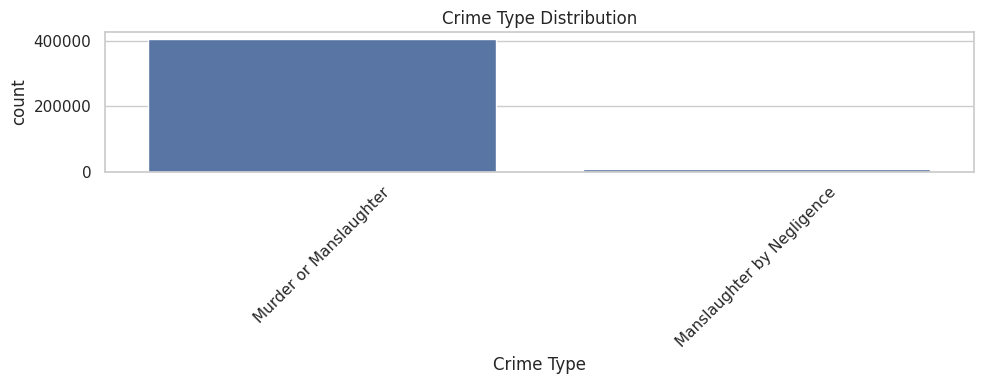

In [ ]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Crime Type')
plt.title('Crime Type Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-11-051adfc73076>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Crime Solved', palette='Set2')


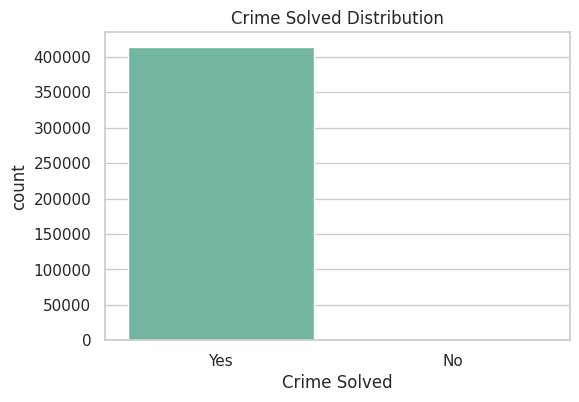

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Crime Solved', palette='Set2')
plt.title('Crime Solved Distribution')
plt.show()

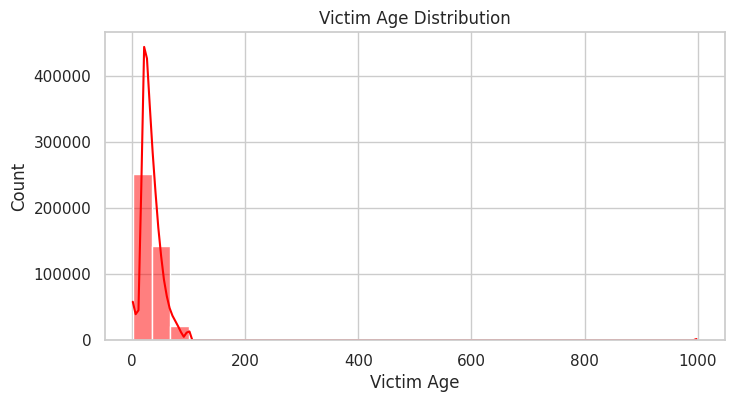

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Victim Age'], bins=30, kde=True, color='red')
plt.title('Victim Age Distribution')
plt.show()

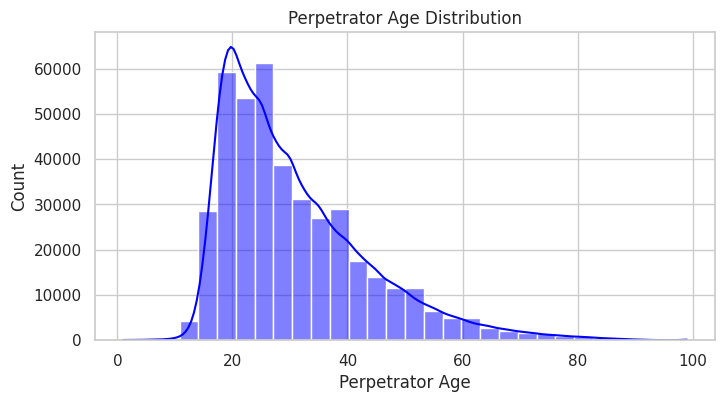

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Perpetrator Age'], bins=30, kde=True, color='blue')
plt.title('Perpetrator Age Distribution')
plt.show()

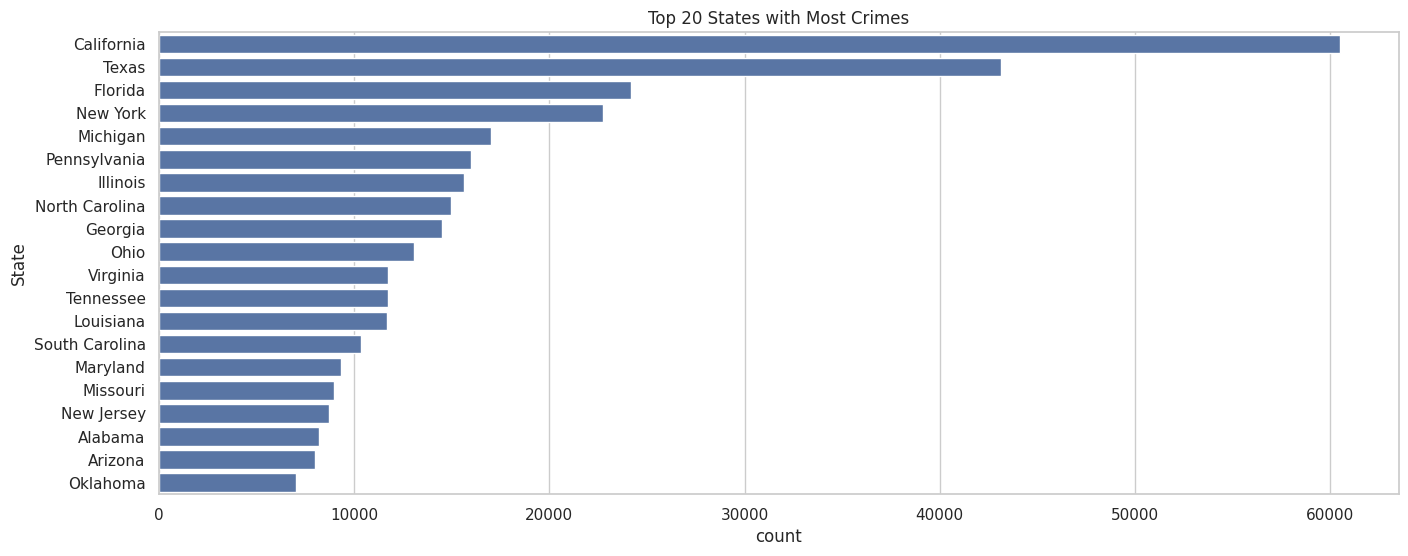

In [ ]:
plt.figure(figsize=(16, 6))
sns.countplot(data=df, y='State', order=df['State'].value_counts().index[:20])
plt.title('Top 20 States with Most Crimes')
plt.show()

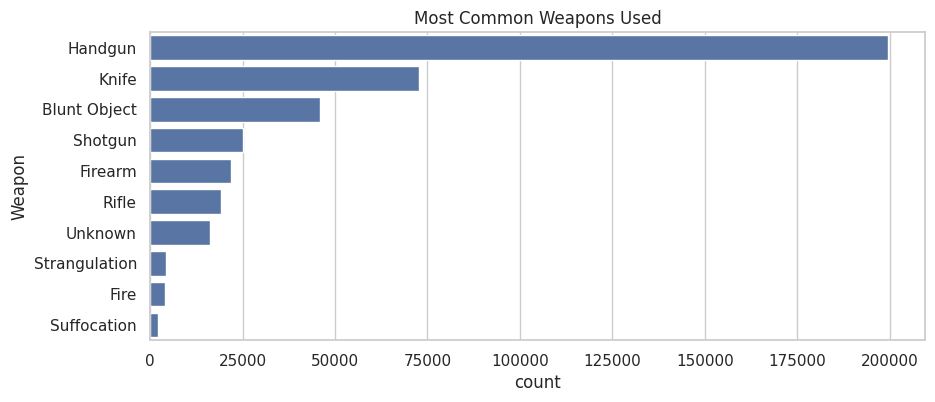

In [ ]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, y='Weapon', order=df['Weapon'].value_counts().index[:10])
plt.title('Most Common Weapons Used')
plt.show()

In [ ]:
def detect_and_remove_outliers_iqr_plot(df, column):
    plt.figure(figsize=(10, 5))


    plt.subplot(1, 2, 1)
    sns.boxplot(x=df[column], color='orange')
    plt.title(f'{column} - Before Outlier Removal')


    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df_clean = df[(df[column] >= lower) & (df[column] <= upper)]


    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_clean[column], color='green')
    plt.title(f'{column} - After Outlier Removal')

    plt.tight_layout()
    plt.show()

    return df_clean


In [ ]:
df.columns

Index(['Record ID', 'Agency Code', 'Agency Name', 'Agency Type', 'City',
       'State', 'Year', 'Month', 'Incident', 'Crime Type', 'Crime Solved',
       'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity',
       'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race',
       'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Victim Count',
       'Perpetrator Count', 'Record Source'],
      dtype='object')

In [ ]:
df.dtypes

,0
Record ID,int64
Agency Code,object
Agency Name,object
Agency Type,object
City,object
State,object
Year,int64
Month,object
Incident,int64
Crime Type,object


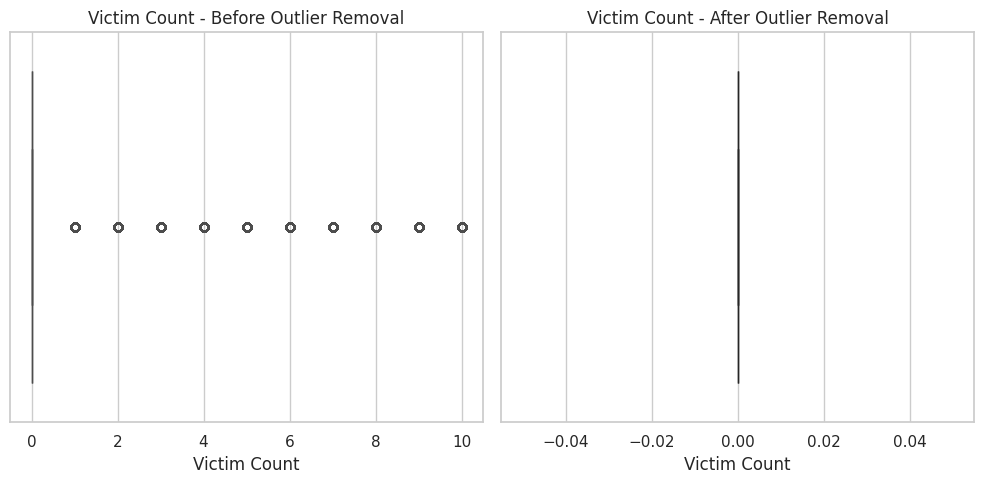

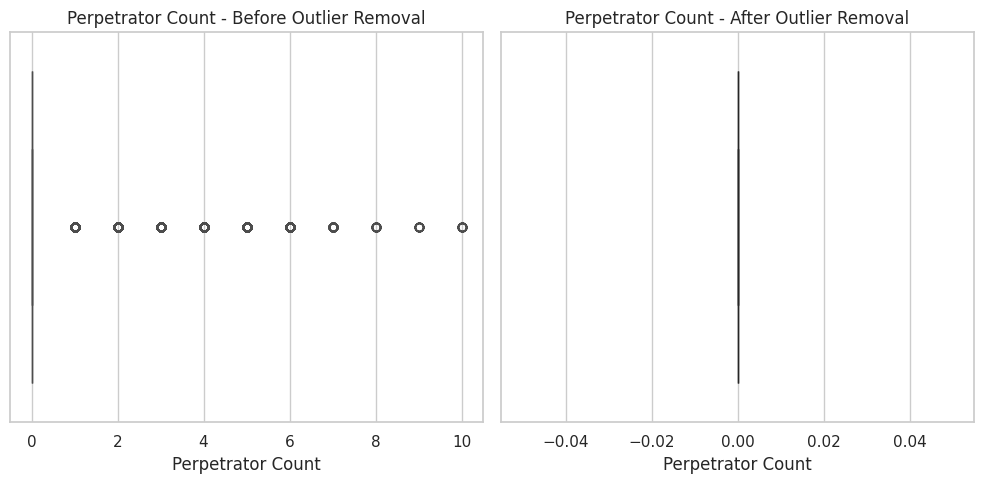

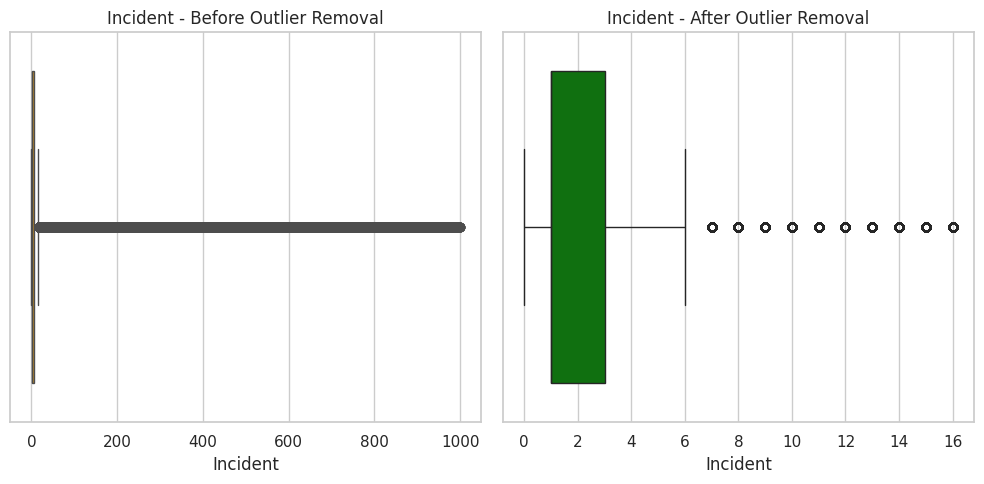

In [ ]:
df = detect_and_remove_outliers_iqr_plot(df, 'Victim Count')
df = detect_and_remove_outliers_iqr_plot(df, 'Perpetrator Count')
df = detect_and_remove_outliers_iqr_plot(df, 'Incident')

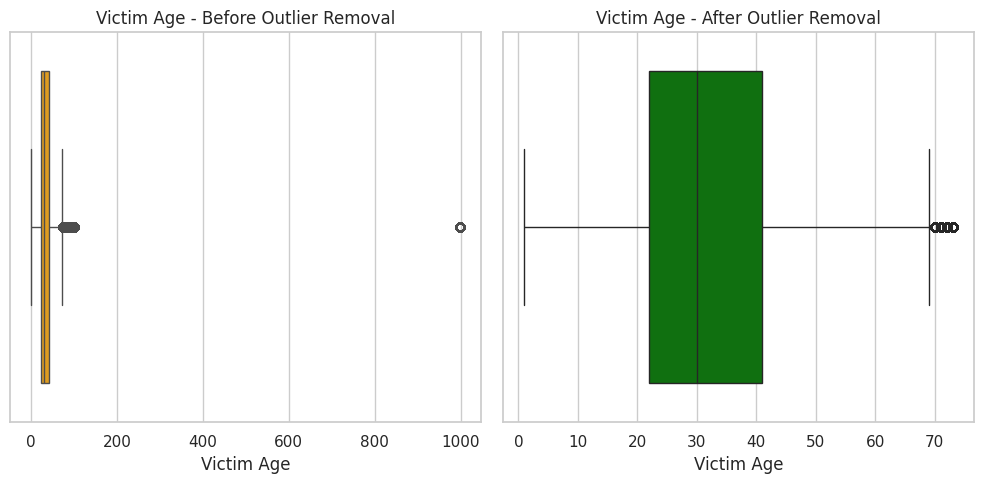

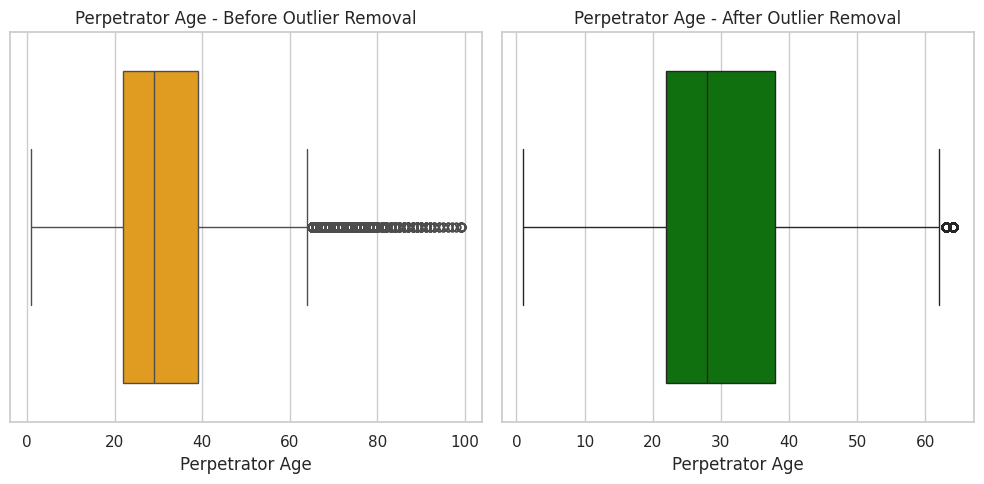

In [ ]:
df = detect_and_remove_outliers_iqr_plot(df, 'Victim Age')
df = detect_and_remove_outliers_iqr_plot(df, 'Perpetrator Age')

In [ ]:
agg_df = df.groupby(['State', 'Year']).agg({
    'Incident': 'count',
    'Victim Age': 'mean',
    'Perpetrator Age': 'mean',
    'Victim Sex': lambda x: x.mode()[0],
    'Perpetrator Sex': lambda x: x.mode()[0],
    'Weapon': lambda x: x.mode()[0],
    'Agency Type': lambda x: x.mode()[0],
    'Crime Solved': lambda x: (x == 'Yes').mean()
}).reset_index()

agg_df.rename(columns={
    'Incident': 'Total Crimes',
    'Crime Solved': 'Solved Ratio'
}, inplace=True)

In [ ]:
threshold = agg_df['Total Crimes'].quantile(0.7)
agg_df['High Crime Risk'] = (agg_df['Total Crimes'] >= threshold).astype(int)

In [ ]:
le = LabelEncoder()
for col in ['Victim Sex', 'Perpetrator Sex', 'Weapon', 'Agency Type']:
    agg_df[col] = le.fit_transform(agg_df[col])

X = agg_df.drop(['State', 'Total Crimes', 'High Crime Risk'], axis=1)
y = agg_df['High Crime Risk']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
pip install xgboost

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
print("\n Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))


 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       247
           1       0.60      0.48      0.53       105

    accuracy                           0.75       352
   macro avg       0.70      0.67      0.68       352
weighted avg       0.74      0.75      0.74       352



In [ ]:
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
print("\n Logistic Regression Report:")
print(classification_report(y_test, lr_preds))


 Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.81       247
           1       0.00      0.00      0.00       105

    accuracy                           0.69       352
   macro avg       0.35      0.49      0.41       352
weighted avg       0.49      0.69      0.57       352



In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print("\n XGBoost Classifier Report:")
print(classification_report(y_test, xgb_preds))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:25:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 XGBoost Classifier Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       247
           1       0.64      0.53      0.58       105

    accuracy                           0.77       352
   macro avg       0.73      0.70      0.71       352
weighted avg       0.76      0.77      0.77       352



In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)
print("\n K-Nearest Neighbors Report:")
print(classification_report(y_test, knn_preds))


 K-Nearest Neighbors Report:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       247
           1       0.55      0.51      0.53       105

    accuracy                           0.73       352
   macro avg       0.68      0.67      0.67       352
weighted avg       0.73      0.73      0.73       352



In [ ]:
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
print("\n Support Vector Machine Report:")
print(classification_report(y_test, svm_preds))


 Support Vector Machine Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       247
           1       0.59      0.28      0.38       105

    accuracy                           0.73       352
   macro avg       0.67      0.60      0.60       352
weighted avg       0.70      0.73      0.69       352



In [ ]:
models = {
    "Random Forest": accuracy_score(y_test, rf_preds),
    "Logistic Regression": accuracy_score(y_test, lr_preds),
    "XGBoost": accuracy_score(y_test, xgb_preds),
    "KNN": accuracy_score(y_test, knn_preds),
    "SVM": accuracy_score(y_test, svm_preds)
}

<ipython-input-33-1f894b88ac9c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(models.values()), y=list(models.keys()), palette="viridis")


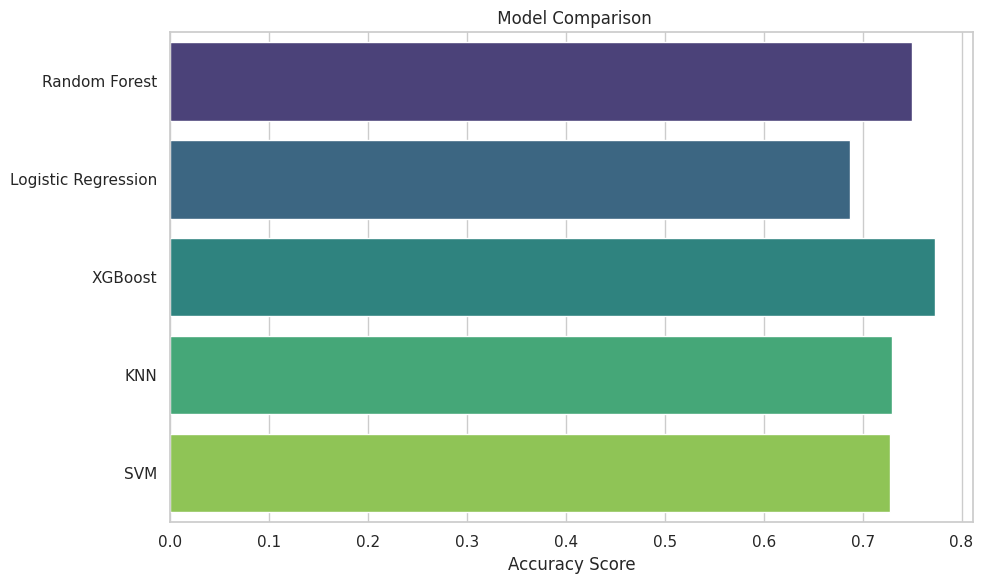

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(models.values()), y=list(models.keys()), palette="viridis")
plt.xlabel("Accuracy Score")
plt.title(" Model Comparison")
plt.tight_layout()
plt.show()

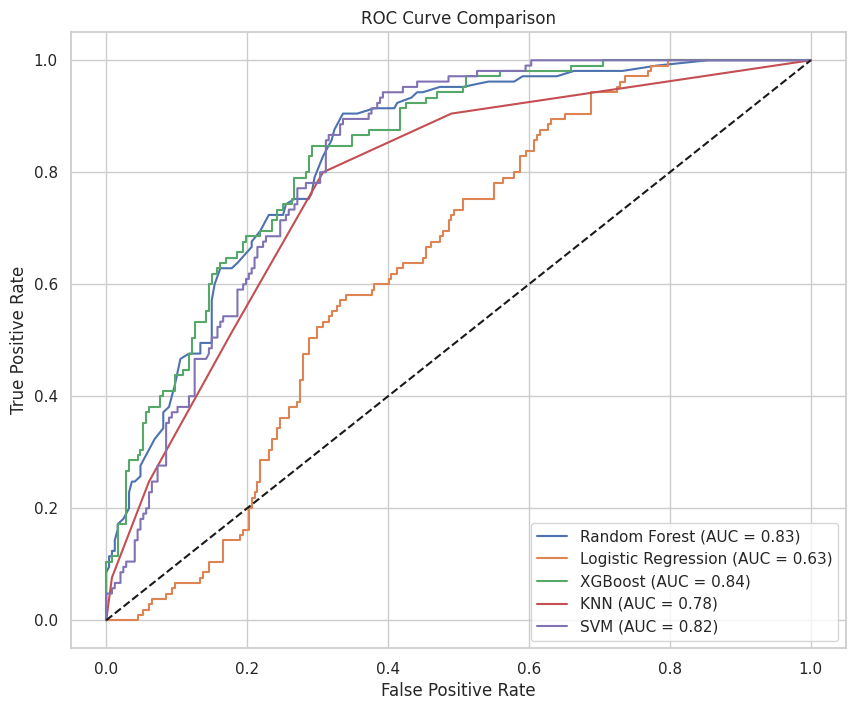

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# For ROC Curves (only works for binary classification)
models_list = [
    ('Random Forest', rf_model),
    ('Logistic Regression', lr_model),
    ('XGBoost', xgb_model),
    ('KNN', knn_model),
    ('SVM', svm_model)
]

plt.figure(figsize=(10, 8))
for name, model in models_list:
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        continue  # Skip models without predict_proba
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [ ]:
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(lr_model, "lr_model.pkl")
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(knn_model, "knn_model.pkl")
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']